Actor-Critic Rocket
---

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
#create a rocket ready to launch.
class rocket:
    def __init__(self,
                 g = 9.81,
                 dry_mass = 1.,
                 fuel_mass = 10.,
                 isp = 500.,
                 torque_strength = .1,
                 time_step = .5,
                 drag_coef = 0.75,
                 length = 4,
                 max_fuel_rate = .05, # per second
                 reference_height = 1000 #m, for barometric pressure
                ):
        #keep track of flight time
        self.stopwatch = 0.
        self.time_step = time_step
        self.position = np.array([0.,0.])
        
        #current velocity and pointing direction (not necessarily parallel)
        self.velocity =  np.array([0.,0.])
        self.heading = np.array([0.,1.])
        
        #angular velocity
        self.spin = 0.
        
        #drag
        self.drag_coef = drag_coef
        self.area = 1.
        #the rocket is 4x longer than it is wide, with this ratio being the perpendicular drag to head-on drag.
        self.length = length
        self.reference_height = reference_height
        
        #fuel, mass, and efficiency
        self.fuel_rate = max_fuel_rate
        self.fuel_mass = fuel_mass
        self.dry_mass = dry_mass
        self.isp = isp
        self.torque_strength = torque_strength
        
        #gravity
        self.g = np.array([0., -g])
        
        #keep track of trajectory history
        self.position_history = [
            self.position
        ]
        self.velocity_history = [
            self.velocity
        ]
        self.heading_history = [
            self.heading
        ]
    
    #calculate drag area due to not flying directly forward
    def drag_area(self):
        speed = np.linalg.norm(self.velocity)
        dot = np.dot(self.velocity, self.heading)
        if speed > 0. and dot != 0.:
            heading_velocity_angle = np.arccos(np.clip(dot/(1.*speed), 0, 1)) #heading is always length 1
            this_area = self.area*(1. + np.sin(heading_velocity_angle))
            return this_area
        else:
            return self.area
        
    #adds speed in heading direction and removes fuel
    def fire(self):
        fuel_chunk = self.fuel_rate*self.time_step
        fuel_velocity = self.isp*np.linalg.norm(self.g)
        if fuel_chunk >= self.fuel_mass:
            fuel_chunk = self.fuel_mass
        #remove fuel to fire
        self.fuel_mass -= fuel_chunk
        # change in speed is fuel spent this time step times fuel speed over remaining rocket mass
        dv = fuel_chunk * fuel_velocity / (self.fuel_mass + self.dry_mass)
        # add new speed to the velocity in the direction of heading
        self.velocity = self.velocity + self.heading * dv
    
    #adds rot. velocity and removes fuel
    def torque(self, clockwise = False):
        fuel_chunk = self.fuel_rate*self.time_step
        if fuel_chunk >= self.fuel_mass:
            fuel_chunk = self.fuel_mass
        torque_direction = 1
        if clockwise:
            torque_direction = -1
        self.spin += self.torque_strength * fuel_chunk * self.time_step * torque_direction
        self.fuel_mass -= fuel_chunk
        
    def is_crashed(self):
        if self.position[1] < 0:
            return True
        else:
            return False
    
    def advance(self):
        #advance stopwatch
        self.stopwatch = self.stopwatch + self.time_step
        
        #evolve rocket position in direction of velocity
        self.position = self.position + self.velocity*self.time_step
        self.position_history.append(self.position)
        
        #evolve rocket heading according to spin
        rotation_angle = self.spin * self.time_step
        rotation_matrix = np.array(
            [
                [np.cos(rotation_angle), np.sin(rotation_angle)],
                [-np.sin(rotation_angle), np.cos(rotation_angle)]
            ]
        )
        new_heading = np.matmul(rotation_matrix , self.heading)
        self.heading = new_heading/np.linalg.norm(new_heading)
        self.heading_history.append(self.heading)
        
        #evolve rocket velocity in direction of drag + gravity
        drag = 0.5 * self.drag_coef * self.drag_area() * np.linalg.norm(self.velocity) * self.velocity * np.exp(-self.position[1]/self.reference_height)
        self.velocity = self.velocity + self.time_step * (self.g - drag/(self.dry_mass+self.fuel_mass))
        self.velocity_history.append(self.velocity)
        state = np.array([self.position, self.velocity, self.heading, [self.spin,0]])
        state = np.reshape(state, (1,8))[:, :7]
        return state
        
    def plot_trajectory(self, label = None, to_show = True):
        x = np.array(self.position_history)[:,0]
        y = np.array(self.position_history)[:,1]
        plt.plot(x,y, label = label, )
        if to_show:
            plt.show()

In [3]:
seed = 2022
gamma = 0.99
max_simulation_time = 60*3 #seconds
eps = np.finfo(np.float32).eps.item()

In [4]:
#inputs are the state of the rocket. Seven values returned from rocket.advance()
num_inputs = 7
#actions are fire, torque l, torque r, and off
num_actions = 4
num_hidden = 64

inputs = keras.layers.Input(shape = (num_inputs,))
common = keras.layers.Dense(num_hidden, activation = 'relu')(inputs)
action = keras.layers.Dense(num_actions, activation = 'softmax')(common)
critic = keras.layers.Dense(1)(common)

model = keras.Model(inputs = inputs, outputs = [action, critic])

In [5]:
target_vel = np.array([250., 0.])
target_alt = 250.

#gives a reward value based on the rocket state of position, velocity, heading
def reward(rocket_state, target_velocity = target_vel, target_altitude = target_alt):
    pos_x, altitude, vel_x, vel_y, head_x, head_y, spin = rocket_state[0]
    velocity = np.array([vel_x, vel_y])
    speed_square_error = np.linalg.norm(velocity - target_velocity)**2
    speed_reward = np.linalg.norm(target_velocity)/(speed_square_error + eps)
    altitude_square_error = (altitude - target_altitude)**2
    altitude_reward = 1 / (altitude_square_error + eps)
    total_reward = altitude_reward + speed_reward
    return total_reward
    

running loss: 19.25 at episode 25
running loss: -5.99 at episode 50
running loss: -3.36 at episode 75
running loss: -1.14 at episode 100
running loss: 12.59 at episode 125
running loss: 23.89 at episode 150
running loss: -5.25 at episode 175
running loss: -13.63 at episode 200
running loss: -9.99 at episode 225
running loss: -10.66 at episode 250
running loss: -6.00 at episode 275
running loss: -5.71 at episode 300
running loss: -1.55 at episode 325
running loss: -7.26 at episode 350
running loss: -11.89 at episode 375
running loss: -1.71 at episode 400
running loss: -5.10 at episode 425
running loss: -9.82 at episode 450
running loss: -8.86 at episode 475
running loss: -5.22 at episode 500
running loss: -7.67 at episode 525
running loss: -1.71 at episode 550
running loss: -8.51 at episode 575
running loss: -8.02 at episode 600
running loss: -9.35 at episode 625
running loss: -5.17 at episode 650
running loss: -1.06 at episode 675
running loss: -0.57 at episode 700
running loss: -7.43 

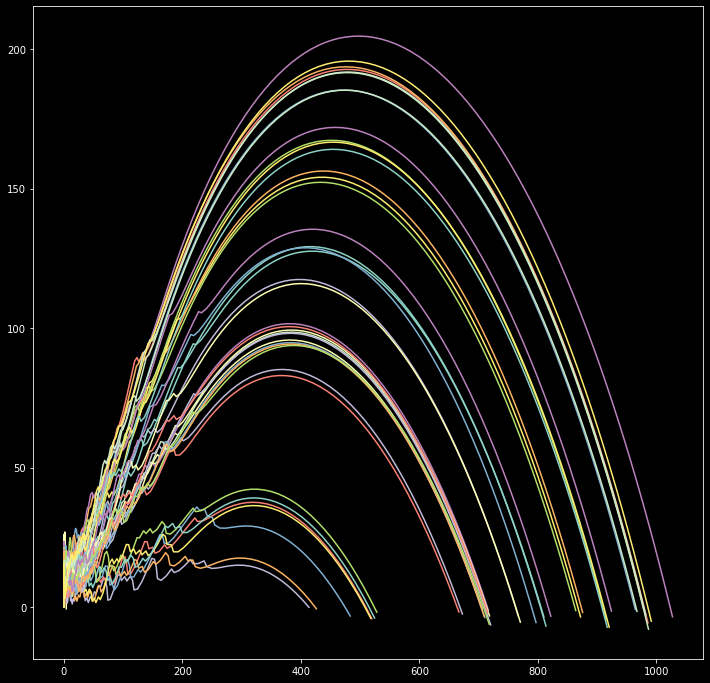

In [7]:
optimizer = tf.optimizers.Adam(learning_rate = 0.001)
huber = tf.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0


rng = np.random.default_rng(seed)

plt.figure(figsize = (12,12))

num_episodes = 1000
episode_update_period = 25

for epoch in range(num_episodes):
    rkt = rocket()
    starting_state = np.array([rkt.position, rkt.velocity, rkt.heading] + [[rkt.spin,0]])
    starting_state = np.reshape(starting_state, (1,8))
    starting_state = starting_state[:,:7]
    state = tf.convert_to_tensor(starting_state)
    
    episode_reward = 0
    
    with tf.GradientTape() as tape:
        while not rkt.is_crashed() and rkt.stopwatch <= max_simulation_time:
                
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0,0])

            action = rng.choice(num_actions, p = np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            if action == 0:
                rkt.fire()
            elif action == 1:
                rkt.torque()
            elif action == 2:
                rkt.torque(clockwise=True)
            elif action == 3:
                pass
            else:
                print('something went wrong in assigning an action.')

            state = rkt.advance()
            state = tf.reshape(state, (1,7,))
            
            this_reward = reward(state)
            
            rewards_history.append(this_reward)
            episode_reward += this_reward
        
        running_reward = 0.05 * episode_reward + (1-0.05) * running_reward
        
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma*discounted_sum
            returns.insert(0, discounted_sum)
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()
        
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            diff = ret - value
            actor_losses.append(-log_prob*diff)
            critic_losses.append(
                huber(tf.expand_dims(value, 0), tf.expand_dims(ret,0))
            )
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
        
    episode_count += 1
    if episode_count % episode_update_period == 0:
        template = 'running loss: {:.2f} at episode {}'
        print(template.format(loss_value, episode_count))
        
        rkt.plot_trajectory(label=f'episode {episode_count}, remaining fuel {rkt.fuel_mass}, stopwatch {rkt.stopwatch}', to_show=False)
# plt.legend();

In [ ]:
rkt.stopwatch

In [ ]:
rkt.fuel_mass
